# EEG-Based Gesture Classification Using CNN, LSTM, and Hybrid CNN-LSTM Models

## Prepare the Models

### Dataset

Data Preparation

In [ ]:
# Load the dataset from a CSV file.
df = pd.read_csv("EEG-data.csv")

# Adjust gesture labels to be zero-indexed
df['gesture'] = df['gesture'] - 1

# Define helper function to print in color
def print_color(text, color):
    """Prints text in specified ANSI color."""
    colors = {
        "red": "\033[91m",
        "green": "\033[92m",
        "yellow": "\033[93m",
        "blue": "\033[94m",
        "magenta": "\033[95m"
    }
    print(f"{colors[color]}{text}\033[0m")

# Display initial data and dataset structure.
print_color("Head of DataFrame:", "green")
print(df.head())
print_color("Shape of DataFrame:", "green")
print(df.shape)

# Check and display any null values in the dataset.
null_count = df.isnull().sum()
print_color("Null values in each column:", "yellow")
print(null_count)

# List and display unique gestures and subjects to understand data categories.
print_color("Unique gestures (after adjustment to 0-index):", "blue")
print(sorted(df["gesture"].unique()))
print_color("Unique subjects :", "blue")
print(sorted(df["subject"].unique()))

# Windowing Setup
# Set window size and step size for slicing the data.
WINDOW_SIZE = 100  # Number of samples per window.
STEP_SIZE = 50     # Interval at which new windows are created.

# Initialize lists to store windowed data and corresponding labels.
X_list = []
y_list = []

# Group the data by gesture, extracting features for each gesture.
for gesture_id in sorted(df["gesture"].unique()):
    gesture_df = df[df["gesture"] == gesture_id]
    gesture_data = gesture_df[
        ["Channel_1", "Channel_2", "Channel_3", "Channel_4",
         "Channel_5", "Channel_6", "Channel_7", "Channel_8"]
    ].values  # Extract channel data as numpy array.

    # Generate overlapping windows of data.
    for start_idx in range(0, len(gesture_data) - WINDOW_SIZE + 1, STEP_SIZE):
        window_data = gesture_data[start_idx:start_idx + WINDOW_SIZE]
        X_list.append(window_data)
        y_list.append(gesture_id)

# Convert lists to numpy arrays for model processing.
X_array = np.array(X_list)
y_array = np.array(y_list)

np.save("X_eeg.npy", X_array)
np.save("y_eeg.npy", y_array)


# Display shapes of the prepared datasets.
print_color("Shape of X_array:", "red")
print(X_array.shape)
print_color("Shape of y_array:", "red")
print(y_array.shape)

# Print statistics about the data in X_array
print_color("Data statistics in X_array:", "green")
print("Mean:", np.mean(X_array, axis=(0, 1)))  # Mean across all windows and all samples within each window
print("Standard Deviation:", np.std(X_array, axis=(0, 1)))  # Standard deviation across all windows and samples
print("Max value:", np.max(X_array))
print("Min value:", np.min(X_array))


Head of DataFrame:
      Channel_1     Channel_2     Channel_3     Channel_4     Channel_5  \
0  65382.115886  57145.654517  11735.984592 -28251.241535  29642.615276   
1  65360.747619  57116.731360  11884.221361 -27993.145942  29687.050544   
2  65359.115941  57136.378543  11781.202171 -27976.382134  29663.134177   
3  65401.181924  57195.007169  11626.930431 -28226.185230  29623.660996   
4  65415.688207  57188.838087  11710.838879 -28288.568948  29646.280962   

      Channel_6     Channel_7     Channel_8  subject  gesture  repetition  
0  49057.452268  11915.424396  41621.608033        4        0           1  
1  49433.140389  11884.020195  41672.793528        4        0           1  
2  49505.381227  11898.682940  41653.056938        4        0           1  
3  49142.277139  11955.031688  41608.867539        4        0           1  
4  49010.513605  11954.361135  41636.181371        4        0           1  
Shape of DataFrame:
(564641, 11)
Null values in each column:
Channel_1    

Data Visualization

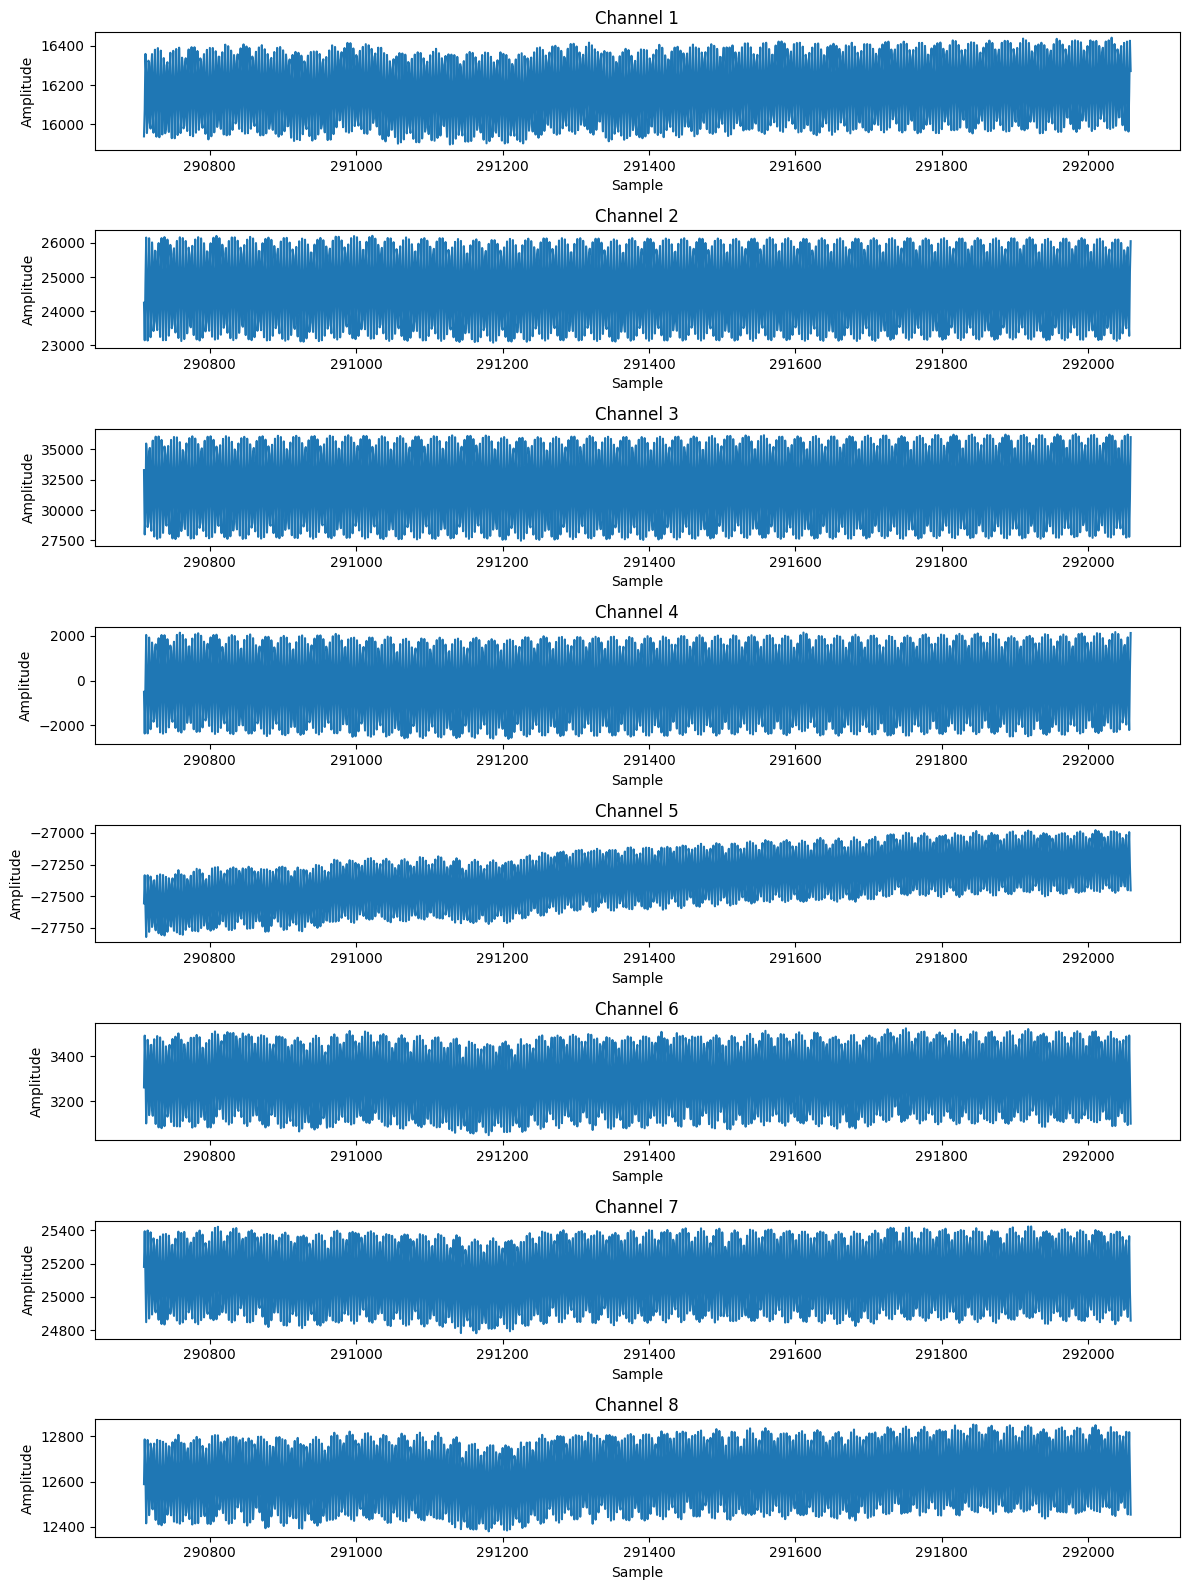

In [ ]:
# Filter the DataFrame for Subject 1, Gesture 1, Repetition 1
filtered_df = df[(df['subject'] == 1) & (df['gesture'] == 1) & (df['repetition'] == 1)]

# Plot each EMG channel
plt.figure(figsize=(12, 16))
for i in range(1, 9):
    plt.subplot(8, 1, i)
    plt.plot(filtered_df[f'Channel_{i}'])
    plt.title(f'Channel {i}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


Split Data into Training and Testing Sets

In [ ]:
# Split the windowed data into 80% training and 20% testing sets, ensuring reproducibility with a fixed random state.
x_train, x_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=42)

# Output the shapes of the training and testing datasets to verify the split.
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


x_train shape: (9027, 100, 8)
y_train shape: (9027,)
x_test shape: (2257, 100, 8)
y_test shape: (2257,)


Normalize Data (Optionally Per Channel)

In [ ]:
# Reshape the training and testing data to flatten the windows for easier normalization calculations.
train_reshaped = x_train.reshape(-1, x_train.shape[-1])  # Flattens the training data.
test_reshaped = x_test.reshape(-1, x_test.shape[-1])     # Flattens the testing data.

# Calculate mean and standard deviation from the training data to prevent data leakage.
mean = train_reshaped.mean(axis=0)
std = train_reshaped.std(axis=0)
std[std == 0] = 1.0  # Avoid division by zero by setting zero standard deviations to one.

# Normalize training and testing data using the calculated mean and standard deviation.
train_reshaped = (train_reshaped - mean) / std
test_reshaped = (test_reshaped - mean) / std

# Reshape the data back to its original windowed format.
x_train_norm = train_reshaped.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2])
x_test_norm = test_reshaped.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2])

# Print the shapes of the normalized datasets to confirm the dimensions are maintained.
print("x_train_norm shape:", x_train_norm.shape)
print("x_test_norm shape:", x_test_norm.shape)

print("x_train_norm shape:", y_train.shape)
print("x_test_norm shape:", y_test.shape)


x_train_norm shape: (9027, 100, 8)
x_test_norm shape: (2257, 100, 8)
x_train_norm shape: (9027,)
x_test_norm shape: (2257,)


Convert labels to one-hot encoding

In [ ]:
num_classes = df['gesture'].nunique()

# Output the shapes to verify correct dimensions
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Convert class vectors to binary class matrices
y_train_oh = to_categorical(y_train, num_classes=num_classes)
y_test_oh = to_categorical(y_test, num_classes=num_classes)

# Output the shapes to verify correct dimensions
print("y_train_oh shape:", y_train_oh.shape)
print("y_test_oh shape:", y_test_oh.shape)

print("Example one-hot label from y_test_oh:", y_test_oh[-1, :])





y_train shape: (9027,)
y_test shape: (2257,)
y_train_oh shape: (9027, 7)
y_test_oh shape: (2257, 7)
Example one-hot label from y_test_oh: [0. 0. 0. 0. 0. 0. 1.]


### 1D CNN, LSTM and hybrid CNN-LSTM models

1D CNN model

In [ ]:
def build_cnn_1d_model(win_size, num_channels, num_classes):
    """
    Builds a 1D Convolutional Neural Network for EMG time-series data.

    Args:
        win_size (int): Number of time steps in each window (e.g., 100).
        num_channels (int): Number of EMG channels (e.g., 8).
        num_classes (int): Number of gesture classes.

    Returns:
        model (tf.keras.Model): Compiled 1D CNN model.
    """
    model = models.Sequential()

    # Convolution Block 1
    model.add(layers.Conv1D(filters=32, kernel_size=3, padding='same',
                            input_shape=(win_size, num_channels)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Dropout(0.2))

    # Convolution Block 2
    model.add(layers.Conv1D(filters=64, kernel_size=3, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Dropout(0.2))

    # Flatten + Dense Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))

    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile Model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


LSTM model

In [ ]:
def build_lstm_model(win_size, num_channels, num_classes):
    """
    Builds a stacked LSTM network for EMG time-series data.

    Args:
        win_size (int): Number of time steps in each window (e.g., 100).
        num_channels (int): Number of EMG channels (e.g., 8).
        num_classes (int): Number of gesture classes.

    Returns:
        model (tf.keras.Model): Compiled LSTM model.
    """
    model = models.Sequential()

    # First LSTM Layer
    model.add(layers.LSTM(64, return_sequences=True,
                          input_shape=(win_size, num_channels)))
    model.add(layers.Dropout(0.2))

    # Second LSTM Layer
    model.add(layers.LSTM(64))
    model.add(layers.Dropout(0.2))

    # Dense + Output Layer
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile Model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


CNN + LSTM Model

In [ ]:
def build_cnn_lstm_model(win_size, num_channels, num_classes):
    """
    Builds a hybrid CNN-LSTM model for EMG time-series data.

    Args:
        win_size (int): Number of time steps in each window (e.g., 100).
        num_channels (int): Number of EMG channels (e.g., 8).
        num_classes (int): Number of gesture classes.

    Returns:
        model (tf.keras.Model): Compiled CNN-LSTM model.
    """
    model = models.Sequential()

    # --- CNN Block ---
    model.add(layers.Conv1D(filters=32, kernel_size=3, padding='same',
                            input_shape=(win_size, num_channels)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv1D(filters=64, kernel_size=3, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Dropout(0.2))

    # At this point, the shape is (batch, new_time_steps, 64)
    # Flattening entirely would remove the time dimension, so instead we pass it to LSTM:

    # --- Recurrent Block ---
    model.add(layers.LSTM(64, return_sequences=False))
    # You could also stack more LSTM layers:
    # e.g., model.add(layers.LSTM(64, return_sequences=False))

    model.add(layers.Dropout(0.3))

    # --- Dense Output Layer ---
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


### Train and Evaluate

In [ ]:
EPOCHS = 100
BATCH_SIZE = 32

Train and Evaluate 1D CNN

In [ ]:
# Build the CNN model
cnn_model = build_cnn_1d_model(
    win_size=x_train_norm.shape[1],   # e.g., 100
    num_channels=x_train_norm.shape[2],
    num_classes=y_train_oh.shape[1]   # e.g., 8
)

# Summarize the model
cnn_model.summary()

# Train the CNN
history_cnn = cnn_model.fit(
    x_train_norm, y_train_oh,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Evaluate on test set
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(x_test_norm, y_test_oh, verbose=0)
print(f"1D CNN Test Accuracy: {test_acc_cnn:.4f}")
print(f"1D CNN Test Loss: {test_loss_cnn:.4f}")

# Generate predictions for classification report
y_pred_cnn = cnn_model.predict(x_test_norm, verbose=0)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
y_true_classes = np.argmax(y_test_oh, axis=1)

# Print classification report
print("\nClassification Report (1D CNN):")
print(classification_report(y_true_classes, y_pred_cnn_classes))

# (Optional) Print confusion matrix
print("Confusion Matrix (1D CNN):")
print(confusion_matrix(y_true_classes, y_pred_cnn_classes))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 100, 32)             │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 50, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 50, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 50, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 25, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 213,223 (832.90 KB)

 Trainable params: 213,031 (832.15 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.2809 - loss: 1.8338 - val_accuracy: 0.4380 - val_loss: 1.4074
Epoch 2/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.4126 - loss: 1.3832 - val_accuracy: 0.5421 - val_loss: 1.1903
Epoch 3/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4891 - loss: 1.2352 - val_accuracy: 0.4762 - val_loss: 1.1523
Epoch 4/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4790 - loss: 1.2082 - val_accuracy: 0.5581 - val_loss: 1.0043
Epoch 5/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5140 - loss: 1.1233 - val_accuracy: 0.5221 - val_loss: 1.0092
Epoch 6/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5219 - loss: 1.1038 - val_accuracy: 0.5786 - val_loss: 1.0115
Epoch 7/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5339 - loss: 1.0648 - val_accuracy: 0.5891 - val_loss: 0.9389
Epoch 8/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5662 - loss: 1.0251 -

Train and Evaluate LSTM

In [ ]:
# Build the LSTM model
lstm_model = build_lstm_model(
    win_size=x_train_norm.shape[1],   # e.g., 100
    num_channels=x_train_norm.shape[2],
    num_classes=y_train_oh.shape[1]   # e.g., 8
)

# Summarize the model
lstm_model.summary()

# Train the LSTM
history_lstm = lstm_model.fit(
    x_train_norm, y_train_oh,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Evaluate on test set
test_loss_lstm, test_acc_lstm = lstm_model.evaluate(x_test_norm, y_test_oh, verbose=0)
print(f"LSTM Test Accuracy: {test_acc_lstm:.4f}")
print(f"LSTM Test Loss: {test_loss_lstm:.4f}")

# Generate predictions for classification report
y_pred_lstm = lstm_model.predict(x_test_norm, verbose=0)
y_pred_lstm_classes = np.argmax(y_pred_lstm, axis=1)
y_true_classes = np.argmax(y_test_oh, axis=1)

# Print classification report
print("\nClassification Report (LSTM):")
print(classification_report(y_true_classes, y_pred_lstm_classes))

# (Optional) Print confusion matrix
print("Confusion Matrix (LSTM):")
print(confusion_matrix(y_true_classes, y_pred_lstm_classes))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 64)             │          18,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,935 (238.03 KB)

 Trainable params: 60,935 (238.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 30s 111ms/step - accuracy: 0.2836 - loss: 1.6824 - val_accuracy: 0.3970 - val_loss: 1.3808
Epoch 2/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 112ms/step - accuracy: 0.3876 - loss: 1.4332 - val_accuracy: 0.4867 - val_loss: 1.2225
Epoch 3/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 113ms/step - accuracy: 0.4623 - loss: 1.2406 - val_accuracy: 0.5393 - val_loss: 1.1414
Epoch 4/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 42s 115ms/step - accuracy: 0.5313 - loss: 1.1019 - val_accuracy: 0.5526 - val_loss: 0.9658
Epoch 5/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - accuracy: 0.5805 - loss: 0.9832 - val_accuracy: 0.5748 - val_loss: 0.9360
Epoch 6/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 40s 113ms/step - accuracy: 0.6299 - loss: 0.8705 - val_accuracy: 0.7254 - val_loss: 0.6703
Epoch 7/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 0.6870 - loss: 0.7536 - val_accuracy: 0.7237 - val_loss: 0.6763
Epoch 8/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - accuracy: 0.7109 -

Train and Evaluate CNN + LSTM

In [ ]:
# Example: after you've prepared your data in (samples, time_steps, channels)
# e.g., x_train_norm, x_test_norm, y_train_oh, y_test_oh

# Build the CNN-LSTM model
hybrid_model = build_cnn_lstm_model(
    win_size=x_train_norm.shape[1],       # e.g., 100
    num_channels=x_train_norm.shape[2],   # e.g., 8
    num_classes=y_train_oh.shape[1]       # e.g., 8
)

hybrid_model.summary()


# Train the CNN-LSTM
history_hybrid = hybrid_model.fit(
    x_train_norm, y_train_oh,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Evaluate on the test set
test_loss_hybrid, test_acc_hybrid = hybrid_model.evaluate(x_test_norm, y_test_oh, verbose=0)
print(f"CNN+LSTM Test Accuracy: {test_acc_hybrid:.4f}")
print(f"CNN+LSTM Test Loss: {test_loss_hybrid:.4f}")

y_pred_hybrid = hybrid_model.predict(x_test_norm)
y_pred_hybrid_classes = np.argmax(y_pred_hybrid, axis=1)
y_true_classes = np.argmax(y_test_oh, axis=1)

print("\nClassification Report (CNN+LSTM):")
print(classification_report(y_true_classes, y_pred_hybrid_classes))
print("Confusion Matrix (CNN+LSTM):")
print(confusion_matrix(y_true_classes, y_pred_hybrid_classes))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 100, 32)             │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 50, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 50, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 50, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 50, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 25, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 25, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,639 (193.90 KB)

 Trainable params: 49,447 (193.15 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.2770 - loss: 1.7495 - val_accuracy: 0.3688 - val_loss: 1.4663
Epoch 2/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.4338 - loss: 1.3449 - val_accuracy: 0.5377 - val_loss: 1.1100
Epoch 3/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.4880 - loss: 1.2064 - val_accuracy: 0.5604 - val_loss: 1.0155
Epoch 4/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.5367 - loss: 1.1224 - val_accuracy: 0.5581 - val_loss: 0.9945
Epoch 5/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5419 - loss: 1.0695 - val_accuracy: 0.6379 - val_loss: 0.9266
Epoch 6/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.5700 - loss: 1.0234 - val_accuracy: 0.6451 - val_loss: 0.8248
Epoch 7/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.5887 - loss: 0.9688 - val_accuracy: 0.6406 - val_loss: 0.8092
Epoch 8/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.6109 - loss: 0.9426

## Compare CNN vs. LSTM vs. CNN-LSTM Models

In [ ]:
def plot_comparison(history_cnn, history_lstm, history_hybrid=None):
    """
    Plots training/validation accuracy and loss for up to three models:
    CNN, LSTM, and optional CNN-LSTM (hybrid).

    Parameters:
    - history_cnn:    Keras History object for CNN
    - history_lstm:   Keras History object for LSTM
    - history_hybrid: Keras History object for CNN-LSTM (optional)
    """

    # Extract accuracies/losses for CNN
    acc_cnn = history_cnn.history['accuracy']
    val_acc_cnn = history_cnn.history['val_accuracy']
    loss_cnn = history_cnn.history['loss']
    val_loss_cnn = history_cnn.history['val_loss']
    epochs_cnn = range(1, len(acc_cnn) + 1)

    # Extract accuracies/losses for LSTM
    acc_lstm = history_lstm.history['accuracy']
    val_acc_lstm = history_lstm.history['val_accuracy']
    loss_lstm = history_lstm.history['loss']
    val_loss_lstm = history_lstm.history['val_loss']
    epochs_lstm = range(1, len(acc_lstm) + 1)

    # Optionally extract accuracies/losses for Hybrid (CNN+LSTM)
    if history_hybrid is not None:
        acc_hyb = history_hybrid.history['accuracy']
        val_acc_hyb = history_hybrid.history['val_accuracy']
        loss_hyb = history_hybrid.history['loss']
        val_loss_hyb = history_hybrid.history['val_loss']
        epochs_hyb = range(1, len(acc_hyb) + 1)
    else:
        acc_hyb, val_acc_hyb, loss_hyb, val_loss_hyb, epochs_hyb = None, None, None, None, None

    # -------------------- ACCURACY PLOT --------------------
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)  # (rows, cols, index)
    # Plot CNN accuracy
    plt.plot(epochs_cnn, acc_cnn, 'b-o', label='CNN Train Acc')
    plt.plot(epochs_cnn, val_acc_cnn, 'b--o', label='CNN Val Acc')
    # Plot LSTM accuracy
    plt.plot(epochs_lstm, acc_lstm, 'r-s', label='LSTM Train Acc')
    plt.plot(epochs_lstm, val_acc_lstm, 'r--s', label='LSTM Val Acc')
    # Plot Hybrid accuracy if available
    if acc_hyb is not None:
        plt.plot(epochs_hyb, acc_hyb, 'g-^', label='Hybrid Train Acc')
        plt.plot(epochs_hyb, val_acc_hyb, 'g--^', label='Hybrid Val Acc')

    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # -------------------- LOSS PLOT --------------------
    plt.subplot(1, 2, 2)
    # Plot CNN loss
    plt.plot(epochs_cnn, loss_cnn, 'b-o', label='CNN Train Loss')
    plt.plot(epochs_cnn, val_loss_cnn, 'b--o', label='CNN Val Loss')
    # Plot LSTM loss
    plt.plot(epochs_lstm, loss_lstm, 'r-s', label='LSTM Train Loss')
    plt.plot(epochs_lstm, val_loss_lstm, 'r--s', label='LSTM Val Loss')
    # Plot Hybrid loss if available
    if loss_hyb is not None:
        plt.plot(epochs_hyb, loss_hyb, 'g-^', label='Hybrid Train Loss')
        plt.plot(epochs_hyb, val_loss_hyb, 'g--^', label='Hybrid Val Loss')

    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


===== Test Performance Comparison =====
1D CNN ->   Test Loss: 0.3807,   Test Accuracy: 0.8542
LSTM  ->    Test Loss: 0.2129,  Test Accuracy: 0.9424
Hybrid ->   Test Loss: 0.2774, Test Accuracy: 0.8888

Summary Table:
-------------------------------------------------
|  Model    |  Test Loss   |  Test Acc  |
-------------------------------------------------
|  CNN      |   0.3807    |   0.8542   |
|  LSTM     |   0.2129    |   0.9424   |
|  Hybrid   |   0.2774    |   0.8888   |
-------------------------------------------------


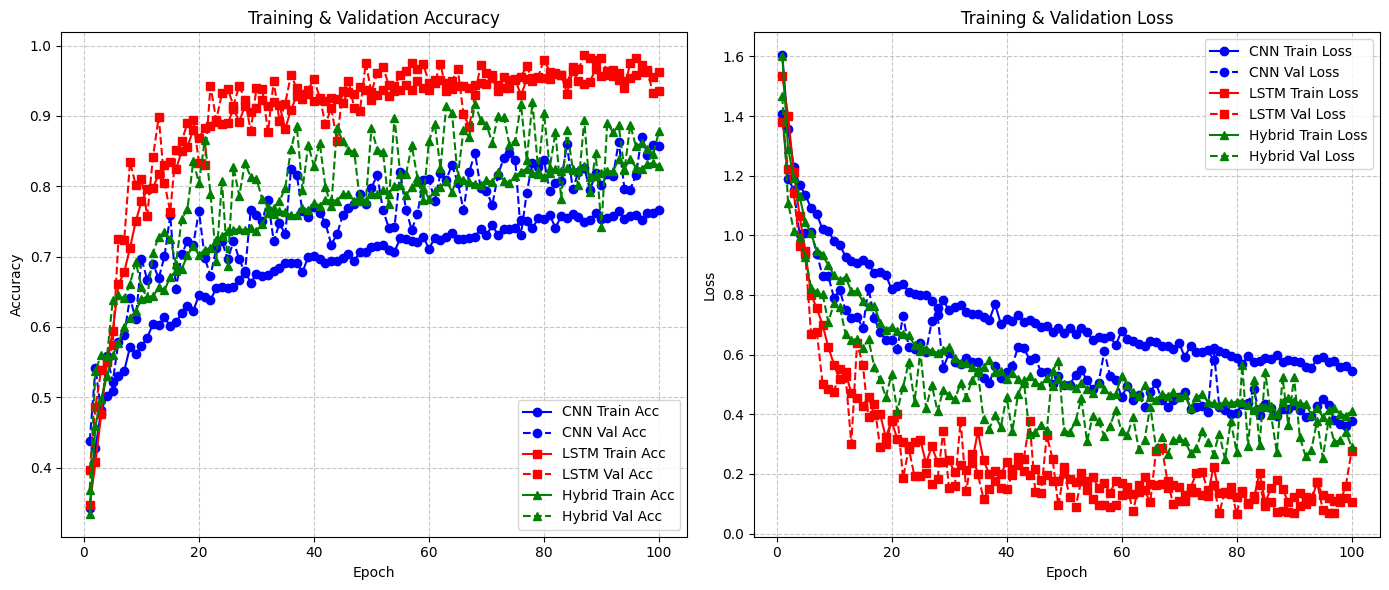

In [ ]:
# Now let's show test performance side-by-side in a simple printout/table.

print("===== Test Performance Comparison =====")
print(f"1D CNN ->   Test Loss: {test_loss_cnn:.4f},   Test Accuracy: {test_acc_cnn:.4f}")
print(f"LSTM  ->    Test Loss: {test_loss_lstm:.4f},  Test Accuracy: {test_acc_lstm:.4f}")
print(f"Hybrid ->   Test Loss: {test_loss_hybrid:.4f}, Test Accuracy: {test_acc_hybrid:.4f}")

print("\nSummary Table:")
print("-------------------------------------------------")
print("|  Model    |  Test Loss   |  Test Acc  |")
print("-------------------------------------------------")
print(f"|  CNN      |   {test_loss_cnn:.4f}    |   {test_acc_cnn:.4f}   |")
print(f"|  LSTM     |   {test_loss_lstm:.4f}    |   {test_acc_lstm:.4f}   |")
print(f"|  Hybrid   |   {test_loss_hybrid:.4f}    |   {test_acc_hybrid:.4f}   |")
print("-------------------------------------------------")

# Finally, call the plotting function:
plot_comparison(history_cnn, history_lstm, history_hybrid)